# 2. Next 7-day forecasting of COVID-19 cases EDA<a id='2_eda'></a>

## 2.1 Contents<a id='2.1_contents'></a>
* [2 Covid-19 EDA](#2_eda)
  * [2.1 Contents](#2.1_contents)  
  * [2.2 Imports](#2.2_imports)
  * [2.3 Functions](#2.3_functions)
      * [2.3.1 Function: string to float](#2.3.1_string_to_float)
      * [2.3.2 Function: visualize cases in different countries](#2.3.2_visualize_cases)
      * [2.3.3 Function: visualize mobility data and cases](#2.3.3_visualize_mobility_cases)
      * [2.3.4 Function: get feature correlations](#2.3.4_get_feature_correlations)
  * [2.4 Load data](#2.4_load_data)
  * [2.5 Explore the data](#2.5_explore_data)
      * [2.5.1 Explore the data: plot mobility, vaccination, cases](#2.5.1_plot_mobility_vaccination_cases)
      * [2.5.2 Explore the data: plot timecourses of COVID-19 cases in 5 countries](#2.5.2_plot_cases_different_countries)
      * [2.5.3 Explore the data: visualize feature correlations](#2.5.3_visualize_feature_correlations)
          * [2.5.3.1 Explore the data: compute the correlation matrix](#2.5.3.1_compute_correlation_matrix)
          * [2.5.3.2 Explore the data: visualize the correlation matrix](#2.5.3.2_visualize_correlation_matrix)
          * [2.5.3.3 Explore the data: visualize the pairwise correlation](#2.5.3.3_visualize_pairwise_correlation)
          * [2.5.3.4 Explore the data: time-evolving correlations between vaccination and COVID-19 cases](#2.5.3.4_time_evolving_correlation_between_vaccination_case)
  * [2.6 Summary](#2.6_summary)

## 2.2 Imports<a id='2.2_imports'></a>

In [45]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import pickle
from datetime import date, timedelta

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

## 2.3 Functions <a id='2.3_functions'></a>

#### 2.3.1 Function: string to float <a id='2.3.1_string_to_float'></a> 

In [287]:
def string_to_float(dict_country, feature_list):
    # converts string formatted features to float 
    # feature_list = ['cloudcover','tempC','humidity','precipMM'] # to convert string formatted weather data
    for country in dict_country.keys():
         dict_country[country][feature_list] = dict_country[country][feature_list].astype(float)
    return dict_country

#### 2.3.2 Function: visualize cases in different countries <a id='2.3.2_visualize_cases'></a>

In [220]:
def cases_visualize(dict_country, country_list): 
    # prepare colors 
    cmp = cm.get_cmap('rainbow')
    this_cmp = cmp(np.arange(0,len(country_list),1))
    
    plt.style.use('dark_background') # plt.style.use('fivethirtyeight')
    xtick_list = []
    country_count = -1
    for country in dict_country.keys(): 
        if country in country_list:
            df = dict_country[country] # dataframe
            plt.plot(df.index, df.case_mil, label=country)
            country_count+=1
            for row in df.iterrows(): 
                ts_curr = row[0]
                if ts_curr.day==1:
                    xtick_list.append(ts_curr) # the first day of each month to be used as xticks
                if row[1].dayow==6:
                    plt.axvline(ts_curr, color='grey', linewidth=1, linestyle=':')
    plt.title('Cases per million' + ' (' + country + ')', fontweight='bold', fontsize=12)
    plt.xlabel('Date', fontweight='bold', fontsize=12)
    plt.xticks(ticks=xtick_list, labels=list(map(lambda x:date.strftime(x,'%b-%d'),xtick_list)), fontsize=12, rotation=45)
    plt.ylabel('Cases per million', fontweight='bold', fontsize=12)
    plt.yticks(fontsize=14)
    fig = plt.gcf()
    fig.set_size_inches(20, 6)
    l = plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1.05), fontsize=14)
    plt.show()   

#### 2.3.3 Function: visualize mobility data and cases <a id='2.3.3_visualize_mobility_cases'></a>

In [109]:
def mob_cases_visualize(dict_country):
    
    for country in dict_country.keys():
    
        df = dict_country[country] # dataframe
        xtick_list = []
        # plot mobility data
        cmp = cm.get_cmap('Accent',7)
        this_cmp = np.concatenate((cmp.colors[0:6], [[1., 1., 1., 1.]]), axis=0)
    
        plt.style.use('dark_background') # plt.style.use('fivethirtyeight')
        ax = df[['rtrc','resi','grph','prks','tran','work','case_mil_percMax']]\
             .plot(color=this_cmp, linewidth=2)
        ax.set_title('Mobility and the number of cases' + ' (' + country + ')', fontweight='bold', fontsize=12)
        ax.set_xlabel('Date', fontweight='bold', fontsize=12)
        ax.set_ylabel('% Change', fontweight='bold', fontsize=12)
        for row in df.iterrows(): 
            ts_curr = row[0]
            if ts_curr.day==1:
                xtick_list.append(ts_curr) # the first day of each month to be used as xticks
            if row[1].holiday==1:
                ax.axvline(ts_curr, color='red', linewidth=1, linestyle=':')
            if row[1].dayow==6:
                ax.axvline(ts_curr, color='grey', linewidth=1, linestyle=':')
        ax.set_xticks(xtick_list)
        ax.set_xticklabels(list(map(lambda x:date.strftime(x,'%b-%d'),xtick_list)), fontsize=10)
        plt.xticks(fontsize=12, rotation=45)
        plt.yticks(fontsize=12)
        ax.figure.set_size_inches(20, 6)
        #ax.grid(False)
        l = ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1.05))
        l.get_texts()[0].set_text('Retail & Recreation')
        l.get_texts()[1].set_text('Residential')
        l.get_texts()[2].set_text('Grocery & Pharmacy')
        l.get_texts()[3].set_text('Parks')
        l.get_texts()[4].set_text('Transportation')
        l.get_texts()[5].set_text('Work')
        l.get_texts()[6].set_text('Cases')
        #plt.show()
        # figure save
        plt.savefig(os.path.join('/Users/parkj/Documents/pyDat/pyDatCode/covid19/Figure', \
                                 country+'_'+'mob_case'+'_LSTM_7d.pdf'))

#### 2.3.4 Function: get feature correlations <a id='2.3.4_get_feature_correlations'></a>

In [313]:
def get_feature_correlations(dict_country, country_list):
    df_combine = dict_country[country_list[0]].drop(['country_region_code','country_region','place_id','vac_percMax','case_mil_percMax'], axis=1)
    for i in range(1,len(country_list)):
        df_combine = df_combine.append(dict_country[country_list[i]].drop(['country_region_code','country_region','place_id','vac_percMax','case_mil_percMax'], axis=1), ignore_index=False)
    corr_matrix = df_combine.corr()
    return corr_matrix, df_combine

## 2.4 Load data <a id='2.4_load_data'></a>

In [2]:
# load the saved dictionary from pickle file
filePath_pickle = Path('/Users/parkj/Documents/pyDat/dataSet/covid_country_data.pickle')
with open(filePath_pickle, 'rb') as f:
    dict_country = pickle.load(f)

## 2.5 Explore the data <a id='2.5_explore_data'></a>

***Note***: our dataset comprises data from ***23*** countries (iso 2-digit country codes: 'AR', 'AU', 'AT', 'BE', 'CA', 'DK', 'FI', 'FR', 'DE', 'IN', 'ID', 'IE', 'IL', 'IT', 'JP', 'KR', 'MX', 'NL', 'NO', 'RU', 'SG', 'GB', 'US'). There is a dataframe for each country that contains various features based upon which the future (cases per million for the next 7 days) COVID-19 cases of each country would be forecased. To undertand how data are organized, let's take a look at US data as an example.   

In [90]:
# overview of the data
dict_country['US'].head()

country_region_code country_region                     place_id  \
date                                                                         
2020-02-15                  US  United States  ChIJCzYy5IS16lQRQrfeQ5K5Oxw   
2020-02-16                  US  United States  ChIJCzYy5IS16lQRQrfeQ5K5Oxw   
2020-02-17                  US  United States  ChIJCzYy5IS16lQRQrfeQ5K5Oxw   
2020-02-18                  US  United States  ChIJCzYy5IS16lQRQrfeQ5K5Oxw   
2020-02-19                  US  United States  ChIJCzYy5IS16lQRQrfeQ5K5Oxw   

            rtrc  grph  prks  tran  work  resi  vac  case_mil cloudcover  \
date                                                                       
2020-02-15   6.0   2.0  15.0   3.0   2.0  -1.0  0.0       0.0         21   
2020-02-16   7.0   1.0  16.0   2.0   0.0  -1.0  0.0       0.0         50   
2020-02-17   6.0   0.0  28.0  -9.0 -24.0   5.0  0.0       0.0         44   
2020-02-18   0.0  -1.0   6.0   1.0   0.0   1.0  0.0       0.0         85   
2020-02-19   2.0   0.0   8.0   1.0   1.0   0.0  0.0       0.0         42   

           tempC humidity precipMM  holiday  dayow  vac_percMax  \
date                                                              
2020-02-15     4       42      0.0        0      5          0.0   
2020-02-16    11       56      0.0        0      6          0.0   
2020-02-17    11       65      0.0        1      0          0.0   
2020-02-18    12       84      4.0        0      1          0.0   
2020-02-19     9       57      5.3        0      2          0.0   

            case_mil_percMax  
date                          
2020-02-15               0.0  
2020-02-16               0.0  
2020-02-17               0.0  
2020-02-18               0.0  
2020-02-19               0.0

In [89]:
# typify the data, and look out for any NaN values
dict_country['US'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 581 entries, 2020-02-15 to 2021-09-17
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   country_region_code  581 non-null    object 
 1   country_region       581 non-null    object 
 2   place_id             581 non-null    object 
 3   rtrc                 581 non-null    float64
 4   grph                 581 non-null    float64
 5   prks                 581 non-null    float64
 6   tran                 581 non-null    float64
 7   work                 581 non-null    float64
 8   resi                 581 non-null    float64
 9   vac                  581 non-null    float64
 10  case_mil             581 non-null    float64
 11  cloudcover           581 non-null    object 
 12  tempC                581 non-null    object 
 13  humidity             581 non-null    object 
 14  precipMM             581 non-null    object 
 15  holiday              

First of all, there is no NaN or missing values in all columns, which has been successfully dealt with during the previous data wrangling stage. Are all data in proper types? The first group of feature variables comprise google mobility data ('rtrc': retail and recreation, 'grph': grocery and pharmacy, 'tran': transportation, 'work': workplace, 'resi': residential area) are all properly in float64 format. Vaccination per million ('vac') is also in float64. However, we note that the weather-related features ('cloudcover': cloud coverage, 'tempC': temperature in celcius, 'humidity': humidity, 'precipMM': precipitation in millimeters) are in string format, which must be tranformed to numeric values to be used in our prediction models. The rest of columns - 'holiday', 'dayow' (day of the week) are properly in int64. 

In [289]:
# convert string formatted weather data to floats
dict_country = string_to_float(dict_country, ['cloudcover','tempC','humidity','precipMM'])

To identify appropriate models for our forecasting, one needs to understand the time-evolving patterns of different time series, i.e., the characteristic temporal patterns of the time series, which could provide some insights as to what features are more relevant with respect to the target variable (the number of COVID-19 cases), what are correlated. Before we dive into the covariance matrix yet, some visualizations would be useful here.    

#### 2.5.1 Explore the data: plot mobility, vaccination, cases <a id='2.5.1_plot_mobility_vaccination_cases'></a>

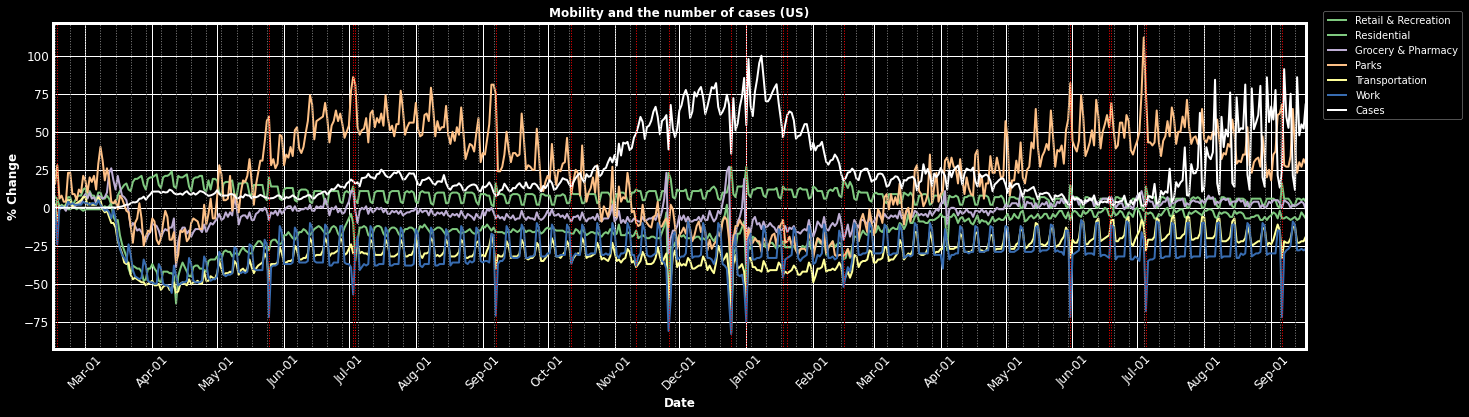

In [110]:
mob_cases_visualize({'US':dict_country['US']})

By plotting the mobility time series and the number of cases on the same plot we first could appreciate that the mobility in different categories displayed characteristic time-evolving patterns, implicating that the data are enriched and potentially informative in forecasting the number of COVID cases. For instance, it is interesting to see that the mobility in parks (yellow) shows interesting negative correlation with the number of cases (white) in US. Our forecasting can leverage such temporal relationship to enhance the model's predictability. Secondly, we observe a robust periodicity in all data, and their frequency of fluctuation is quite obviously weekly. This is an expected pattern as the amount of human traffic at places, for instance, workplaces should vary dramatically during weekdays vs weekends. The impact of such nonlinearity in our model performance is not clear at this point. However, given the observation that the weekly oscillation also exists in the target variable (COVID cases), it could also be used to leverage the model's prediction power, if it could be properly modeled. In addition, widespread periodicity both in features and target implicates that our model would need to possess some complexity to capture the periodicity and dynamic time evoloving patterns, and thus simple approaches like linear regression would perhaps not be the best model choice. 

#### 2.5.2 Explore the data: plot timecourses of COVID-19 cases in 5 countries <a id='2.5.2_plot_cases_different_countries'></a>

Importantly, we also need to decide how to treat 23 different countries. Do data from different countries exhibit similar temporal patterns? We already know that is not the case. Countries have come through wildly different epidemiological footprints due to numerous variables that differed across countries. To showcase this international discrepancy, the number of cases over time is plotted for 5 different countries (for simplicity) below. 

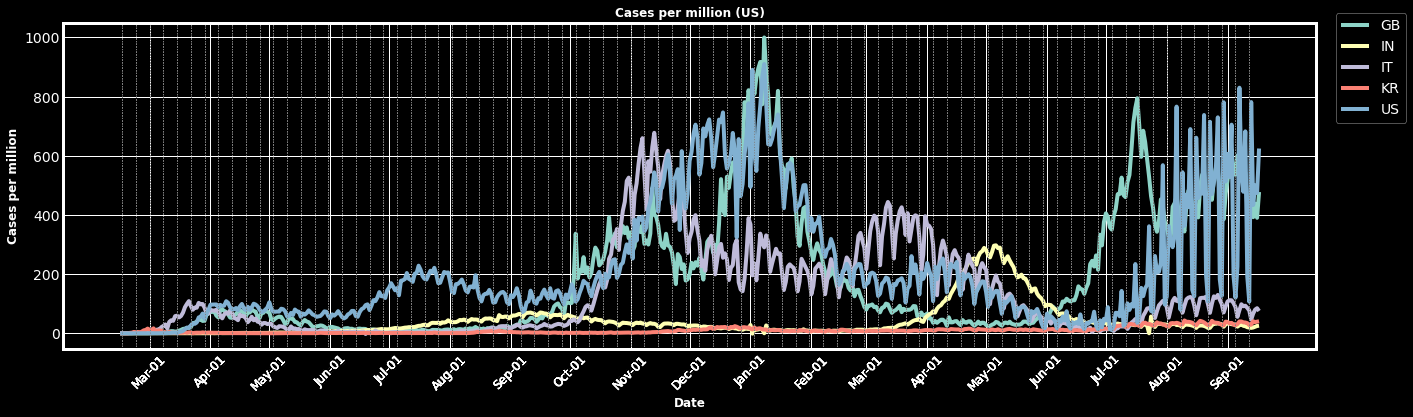

In [221]:
cases_visualize(dict_country, ['US','IT','KR','GB','IN']) # United States, Italy, South Korea, UK, India

As can be seen from above, countries show quite different time-evolving patterns in their COVID-19 cases. This suggests that a unifying model that pools data across different countries would be suboptimal - i.e., models would need to treat different countries differently, in other words, contry ID should be a critical feature in our model predicting the future COVID-19 cases. 

#### 2.5.3 Explore the data: visualize feature correlations <a id='2.5.3_visualize_feature_correlations'></a>

Ok, we've learned that countries differ in COVID-19 cases over time, and so the model should each country differently. Now we ask seek to gain more insights on features and their relevance to the target variable (COVID-19 cases). As a first pass analysis, we turn to the correlation matrix to reveal any linear relationship among features and between feature and the target. To get a general idea first, we pool the data across all countries and compute Pearson's correlations. 

#### 2.5.3.1 Explore the data: compute the correlation matrix <a id='2.5.3.1_compute_correlation_matrix'></a>

In [314]:
feature_corr, df_combine = get_feature_correlations(dict_country, list(dict_country.keys()))
feature_corr.round(3)

rtrc   grph   prks   tran   work   resi    vac  case_mil  \
rtrc        1.000  0.725  0.551  0.747  0.465 -0.738  0.347    -0.189   
grph        0.725  1.000  0.332  0.612  0.446 -0.528  0.406    -0.058   
prks        0.551  0.332  1.000  0.302 -0.020 -0.450  0.388    -0.073   
tran        0.747  0.612  0.302  1.000  0.673 -0.795  0.236    -0.151   
work        0.465  0.446 -0.020  0.673  1.000 -0.735  0.095    -0.129   
resi       -0.738 -0.528 -0.450 -0.795 -0.735  1.000 -0.232     0.112   
vac         0.347  0.406  0.388  0.236  0.095 -0.232  1.000     0.156   
case_mil   -0.189 -0.058 -0.073 -0.151 -0.129  0.112  0.156     1.000   
cloudcover  0.006 -0.036 -0.105 -0.092 -0.005  0.043 -0.048     0.008   
tempC       0.144  0.158  0.044  0.245  0.065 -0.033  0.169    -0.178   
humidity    0.072  0.016  0.080 -0.161 -0.016 -0.004  0.058     0.130   
precipMM    0.002 -0.020 -0.138 -0.034  0.020  0.077 -0.042    -0.056   
holiday    -0.155 -0.265  0.004 -0.156 -0.324  0.205 -0.037    -0.021   
dayow      -0.113 -0.071 -0.025  0.068  0.358 -0.212 -0.002    -0.003   

            cloudcover  tempC  humidity  precipMM  holiday  dayow  
rtrc             0.006  0.144     0.072     0.002   -0.155 -0.113  
grph            -0.036  0.158     0.016    -0.020   -0.265 -0.071  
prks            -0.105  0.044     0.080    -0.138    0.004 -0.025  
tran            -0.092  0.245    -0.161    -0.034   -0.156  0.068  
work            -0.005  0.065    -0.016     0.020   -0.324  0.358  
resi             0.043 -0.033    -0.004     0.077    0.205 -0.212  
vac             -0.048  0.169     0.058    -0.042   -0.037 -0.002  
case_mil         0.008 -0.178     0.130    -0.056   -0.021 -0.003  
cloudcover       1.000 -0.367     0.655     0.415   -0.018  0.002  
tempC           -0.367  1.000    -0.519     0.027    0.005 -0.003  
humidity         0.655 -0.519     1.000     0.278   -0.041  0.006  
precipMM         0.415  0.027     0.278     1.000   -0.005  0.015  
holiday         -0.018  0.005    -0.041    -0.005    1.000 -0.035  
dayow            0.002 -0.003     0.006     0.015   -0.035  1.000

#### 2.5.3.2 Explore the data: visualize the correlation matrix <a id='2.5.3.2_visualize_correlation_matrix'></a>

<AxesSubplot:>

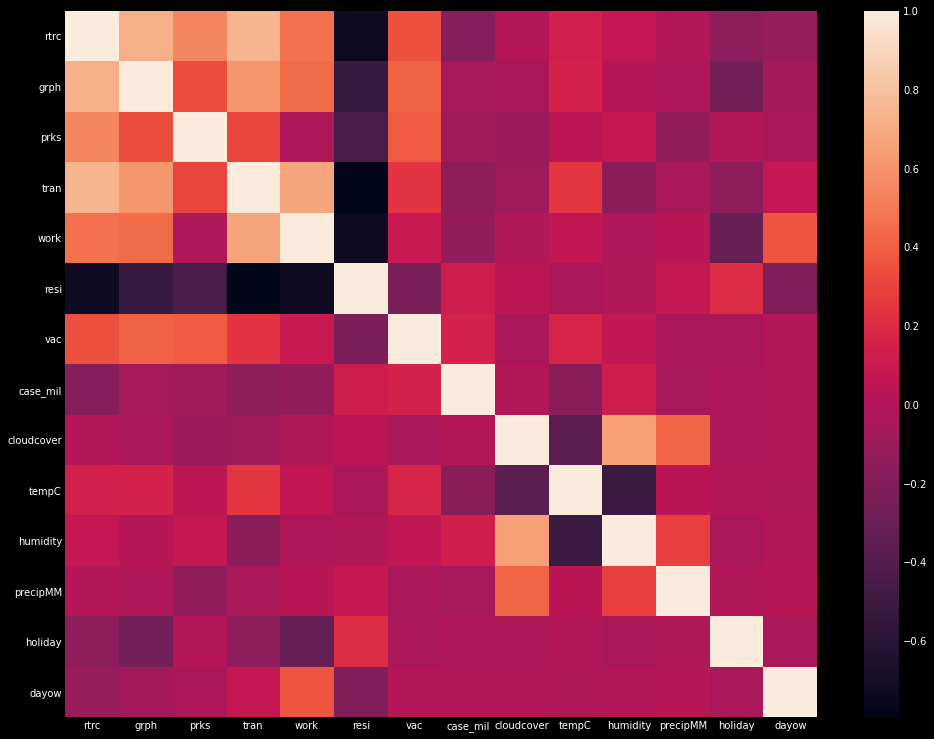

In [408]:
# Make a heatmap of the correlation matrix 
fig = plt.figure(figsize=(15,13))
sns.heatmap(feature_corr)

#### 2.5.3.3 Explore the data: visualize the pairwise correlation <a id='2.5.3.3_visualize_pairwise_correlation'></a>

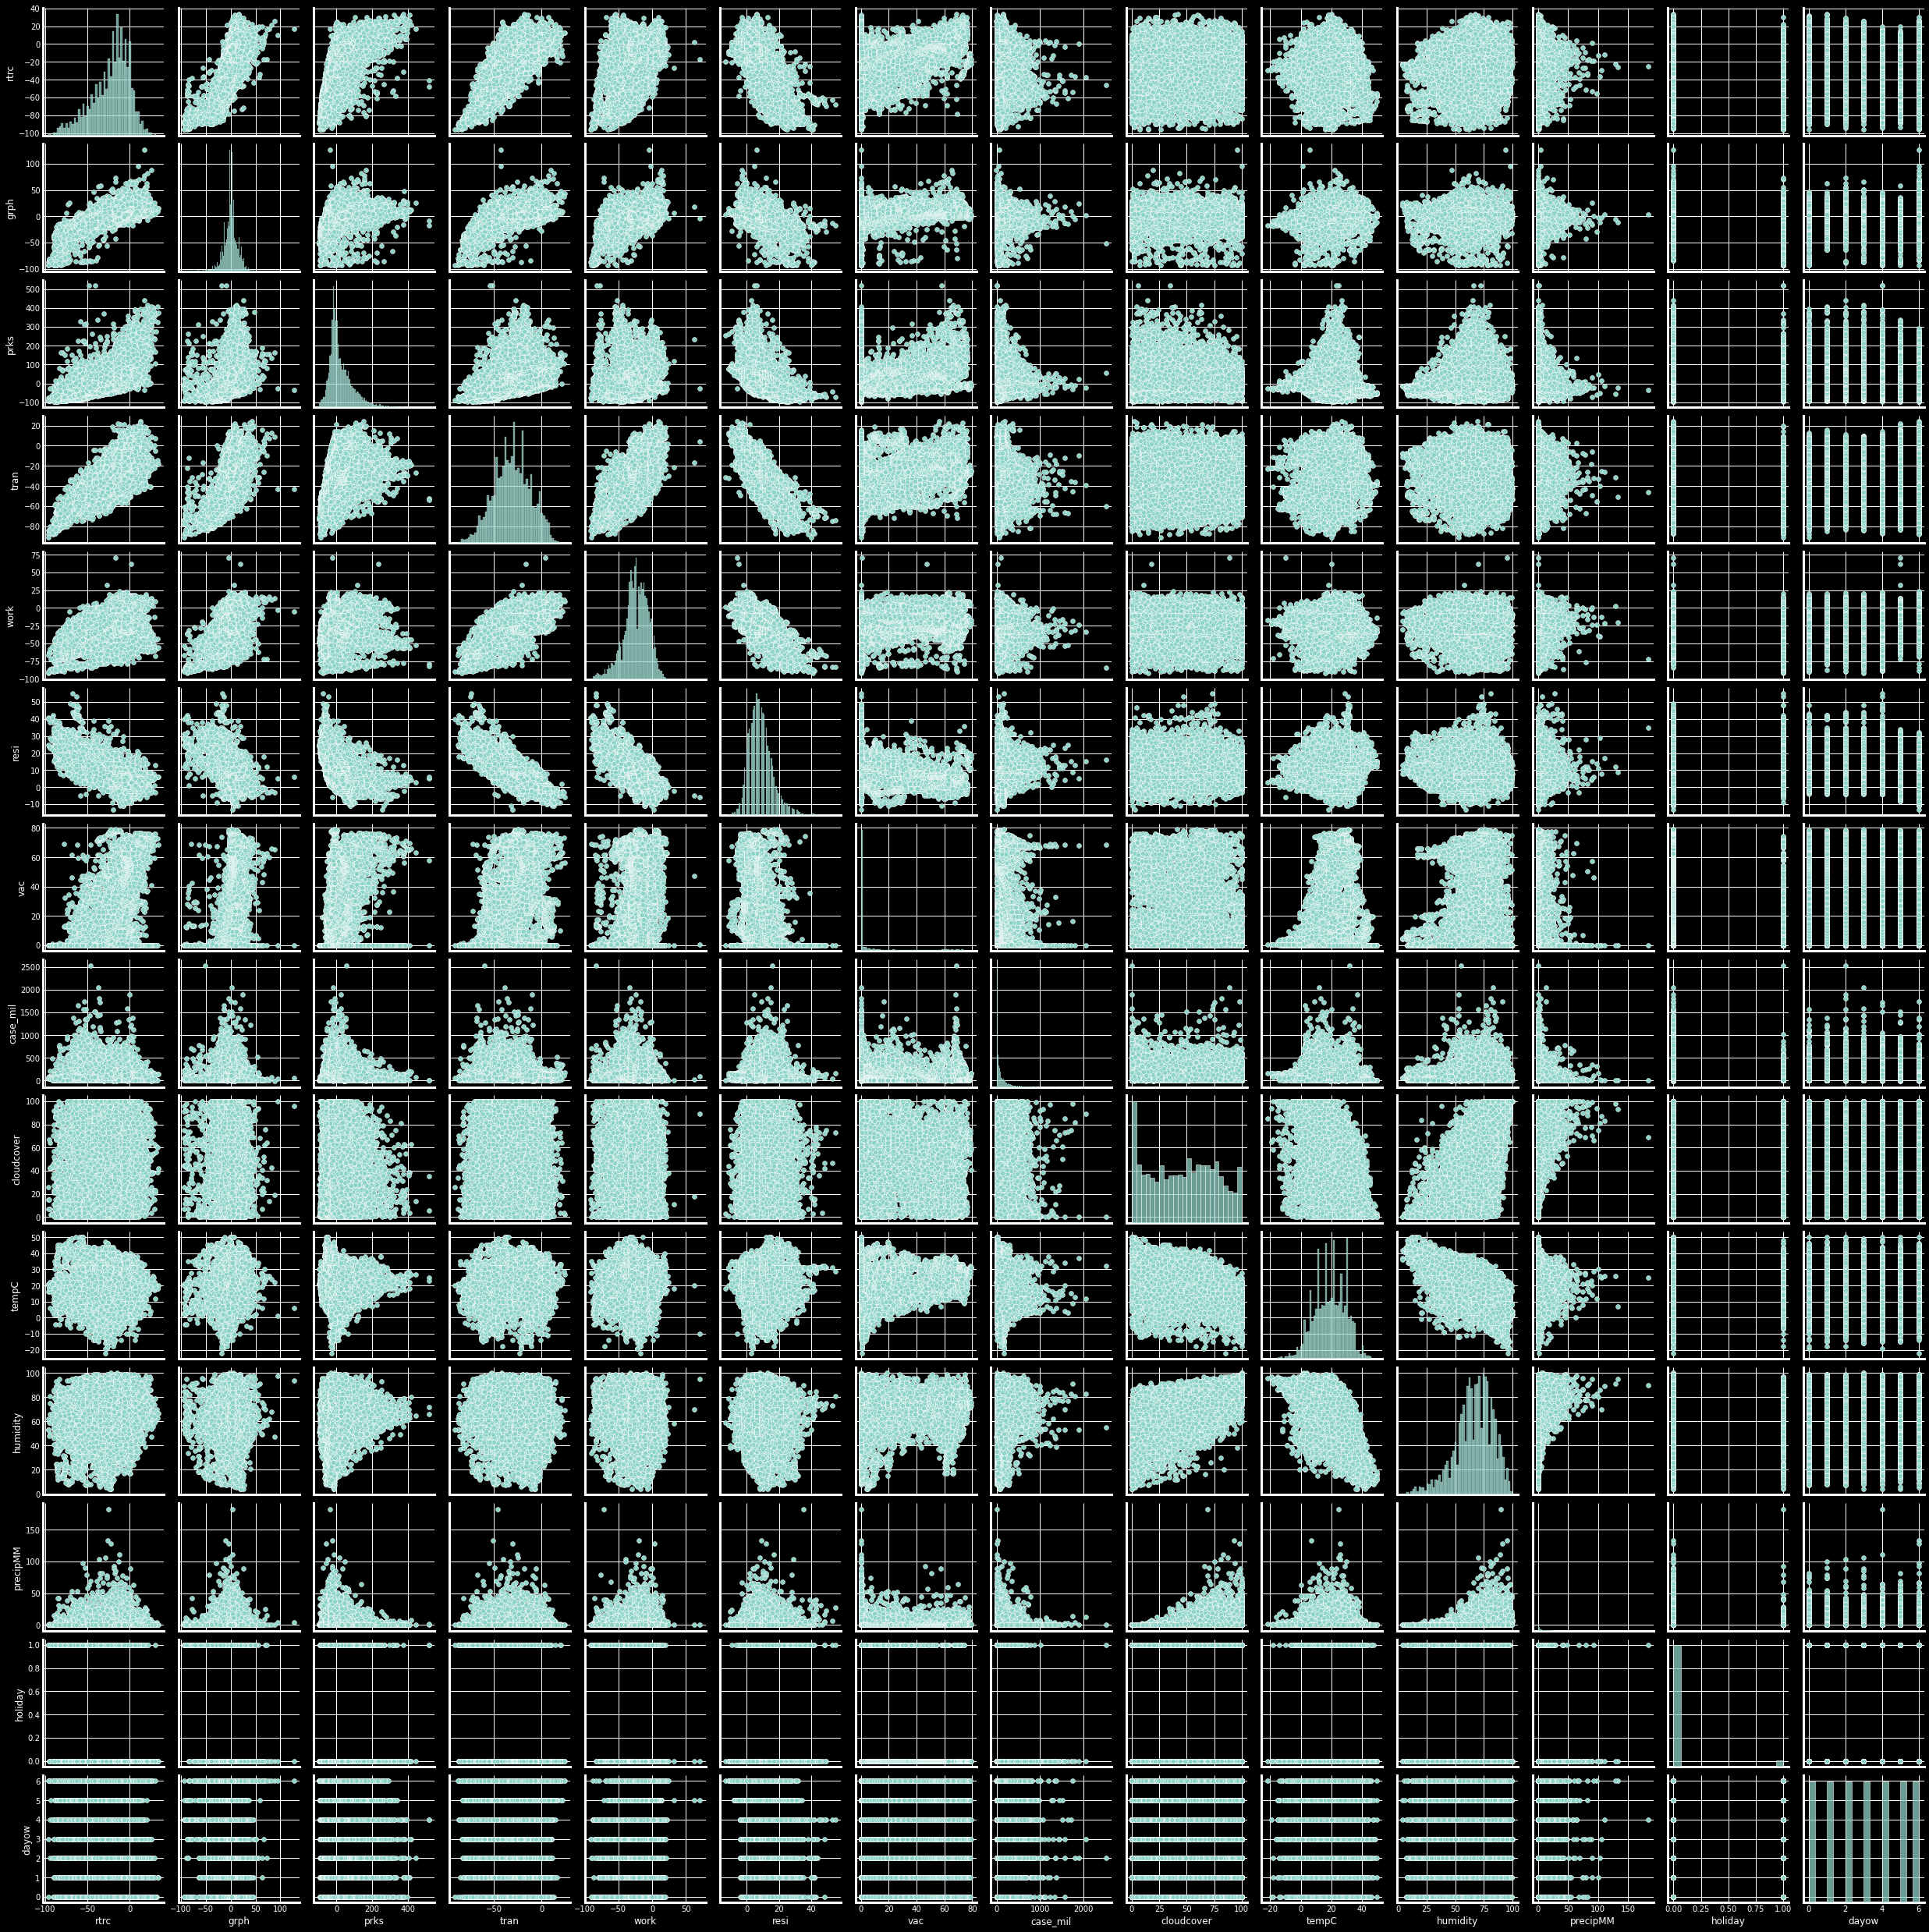

In [306]:
# Make a pairplot of the wine data
sns.pairplot(df_combine)

From the correlation matrix and its visualizations, we've observed interesting relationships among features and between features and the target. 
* Greater positive and negative correlations were observed among mobility or weather features - a good sanity check.
* A number of features showed moderate to strong correlations with the target, which would be advantageous for our prediction models. 
    * Some mobility variables (retail & recreation, transportation, work) showed negative correlation with the number of cases. 
    * The temperature was also negatively correlated with the number of cases, consistent with the general notion. 
    * A negative relationship was expected between the number of vaccination and COVID-19 case, which turned out to be a ***positive*** (0.16) correlation!
        * A positive correlation seems ironical at first sight, but it makes sense given recent increases in both vaccinations and cases due to delta variants. 
        * It is possible that the correlation between vaccinations and cases might change over time, which is further investigated below.    

#### 2.5.3.4 Explore the data: time-evolving correlations between vaccination and COVID-19 cases <a id='2.5.3.4_time_evolving_correlation_between_vaccination_case'></a>

The correlation between cases and vaccinations in US before 6/30/21 is -0.81
The correlation between cases and vaccinations in US after 7/1/21 is 0.64


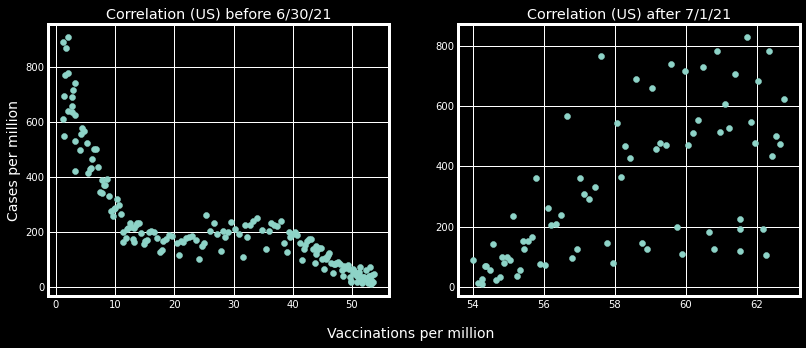

In [425]:
reference_date_1 = pd.to_datetime('2021-01-01', format='%Y-%m-%d')
reference_date_2 = pd.to_datetime('2021-07-01', format='%Y-%m-%d')
df_old = df_us[np.logical_and(df_us.index>reference_date_1,df_us.index<reference_date_2)] # dataframe corresponding to 1/1/21 to 6/30/21
df_new = df_us[df_us.index>reference_date_2] # dataframe corresponding to 7/1/21 and onward

fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(list(df_old.vac), list(df_old.case_mil))
ax2.scatter(list(df_new.vac), list(df_new.case_mil))

# Set common labels
ax1.set_ylabel('Cases per million', fontsize=14)
fig.text(0.5, 0.02, 'Vaccinations per million', ha='center', va='center', fontsize=14)

ax1.set_title('Correlation (US) before 6/30/21')
ax2.set_title('Correlation (US) after 7/1/21')

print("The correlation between cases and vaccinations in US before 6/30/21 is %.2f" \
     %np.corrcoef(np.asarray([list(df_old.vac), list(df_old.case_mil)]))[0,1])
print("The correlation between cases and vaccinations in US after 7/1/21 is %.2f" \
     %np.corrcoef(np.asarray([list(df_new.vac), list(df_new.case_mil)]))[0,1])

As speculated above, the correlations between vaccinations and cases change over time. The correlation started as negative perhaps reflecting the efficacy of vaccines in preventing infections, however the relationship was reversed in recent data, which might be due to the surge of infections from emerging delta variants and other factors like lifting of social distancing measures in many areas. This highlights the complexity in time-evolving patterns of feature time series in this dataset. Thus, models that can capture such complext patterns would be preferred - which is a vote for ensemble methods based on decision trees (e.g. XGBoost) or deep neural networks (ideally the ones with recurrent architecture, e.g., LSTM). 

## 2.6 Summary <a id='2.6_summary'></a>

From a series of exploratory analyses, we have learned, 
* The target variable (COVID-19 cases) displayed complex time-evolving patterns with a great deal of non-linearity (e.g., weekly oscillations). 
    * The non-linearity has to do with seasonality, which is commonly observed in many time series and can be modeled using auto-regressive methods as in many econometric models like ARIMA. 
    * However, classic econometric models might not be readily extended to include other feature variables and complex relationships among them, which perhaps would be much better captured in more complex models. 
* Data from 23 countries in our dataset had characteristic time-evoloing patterns, suggesting that the model needs to treat them differently. 
* Correlation analyses revealed that some feature variables were positively or negatively correlated with the target.
    * We have also noted that some correlations might alter over time, suggesting that complex models might be needed to capture those time-evolving patterns. 
* These considerations make us gravitate towards tree-based ensemble methods and/or recurrent neural network based models. 
    * A better approach would be starting off with simpler models that are commonly used in time series forecasting - persistence model, class econometric models like ARIMA to establish the baseline model performance. 
    * Performance of more advanced models with higher complexity can then be compared one another and compared with the 'baseline' performance of the simpler models.    